### This function reads in images from a directory and predicts the images class using a trained model
#### predict_images(path_to_images, path_to_model, path_to_class_dict, img_shape, preprocess_function,show_images,reverse_function=None ) where
#### path_to_images is the full path to the directory containing the images
#### path_to_model is the full path to the the location of the saved trained model
#### path_to_class_dict is the full path to a text file which is the text version of a dictionary of the form {class_index, class_name}
#### images shape is a tuple of the form (image_height, image_width, bands) for example (224,224,3) This tuple must be the
#### the same as the image size the model was trained on
#### preprocess_function is a function you must define that was used in the original model to preprocess the images. For
#### example if image piixels were scalled to be between -1 to +1 see example of use for definition of the function
#### show_images is a boolean. If set to true a plot is made  with each image shown with its predicted label
#### reverse_function is a function you must define to rescale the pixel back to a range of 0 to 1 so they can be displayed
#### only needed if show_images=True

#### Import need modules

In [1]:
from tensorflow.keras.models import  load_model
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import cv2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#### Define predict_images function

In [2]:
def predict_images(path_to_images, path_to_model, path_to_class_dict, img_shape, preprocess_function,show_images,reverse_function=None ):
    # Read in text form of class dictionary and convert to a dictionary 
    with open(path_to_class_dict,"r") as f: # read in the text form of the dictionary which originally is {class_index: class_name}
        txt_dict = f.read()
    newtxt='' # create an empty string
    for char in txt_dict:  # read each char in the txt file and delete undesired characters
        if char in ['}', '{', '\'', '\""']:           
            char=''
        newtxt=newtxt + char
    txt_split=newtxt.split(',') # split the newtxt string each split will appearas  intger  string 
    class_dict={} # create an impty dictionary
    for c in txt_split:  #iterate through the splits and make key= class_index and value = class_name
        csplit=c.split(':')
        x=int(csplit[0])
        y=csplit[1]    
        class_dict[x]=y 
    # iterate through files in the path_to_images    
    img_list=os.listdir(path_to_images)
    length=len(img_list)
    img_array=np.zeros((length, img_shape[0], img_shape[1], img_shape[2]))
    filenames=[]
    for i, f in enumerate(img_list):
        f_path=os.path.join (path_to_images,f) # define path to the image
        filenames.append(f)           # store the file name
        img=cv2.imread (f_path)       # read in the file - Note cv2 reads in images as BGR
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert image to RGB
        img=cv2.resize(img, (img_shape[0], img_shape[1]))   # resize image to size used to train the model
        img_array[i]=preprocess_function(img) # rescale pixels to range -1 to +1 to be the same as scaled in the model 
        
    model=load_model(path_to_model) # load the model
    predictions=model.predict(img_array)   # make predictions
    msg='{0:^25s}{1:^25s}{2:^15s}{3:^25s}{4:^15s}'.format('File Name', 'Predicted Class', 'Probability', 'Next Likely Class', 'Probability')
    print (msg) # print out header for prediction data
    klass=[]
    for i,p in enumerate(predictions):        
        file_name=filenames[i] # get the file name for the i th prediction
        index=np.argmax(p) # find the index of the column with the highest probability        
        prob=p[index]  # get the value of the highest probability
        klass.append(class_dict[index]) # get the name of the class that has the highest probability
        p[index]=0  # set highest probabilty column value  to 0 so we can get next highest probability
        index=np.argmax(p) # index of column with second highest probability
        prob2=p[index] # second highest probability
        klass2=class_dict[index] # class with second highest probability
        msg='{0:^25s}{1:^25s}{2:^15.4f}{3:^25s}{4:^15.4f}'.format(file_name, klass[i], prob, klass2, prob2)
        print (msg) # print out the data for the i th prediction
    if show_images== True:
        if reverse_function ==None: 
            print ('*** WARNING *** to show images you must define a reverse function')
            return        
        img_array=reverse_function(img_array) # rescale pixel to range 0 to 1 reverse effect of preprocess function
        show(img_array, klass, length )
    return


#### Define function to show images with predicted label

In [3]:
def show(img_array, klass, length):
    # based on number of images define the figure size  and rows given 8 columns
    columns=6
    rows=length//columns + 1
    fig_height=rows * 4
    fig = plt.figure(figsize=(  20, fig_height))
    for row in range(rows):
        for column in range(columns):
            i= row * columns + column             
            if i == length:
                break
            img =img_array[i]
            a = fig.add_subplot(rows, columns, i+1)
            title= klass[i]
            a.set_title(title, color='y', fontsize=14)
            a.axis('off')
            imgplot=plt.imshow(img)
    

#### Example of use

        File Name             Predicted Class       Probability      Next Likely Class      Probability  
         001.jpg                   Afghan             0.9614          Golden Retriever        0.0055     
         002.jpg                   Afghan             0.9843               Borzoi             0.0012     
         003.jpg                   Afghan             0.9625               Borzoi             0.0028     
         004.jpg                   Afghan             0.9787          Golden Retriever        0.0021     
         005.jpg                   Afghan             0.9783               Borzoi             0.0019     
         006.jpg                   Afghan             0.9666               Borzoi             0.0058     
         007.jpg                   Afghan             0.9584               Borzoi             0.0030     
         008.jpg                   Afghan             0.9406               Borzoi             0.0054     
         009.jpg                   Afghan     

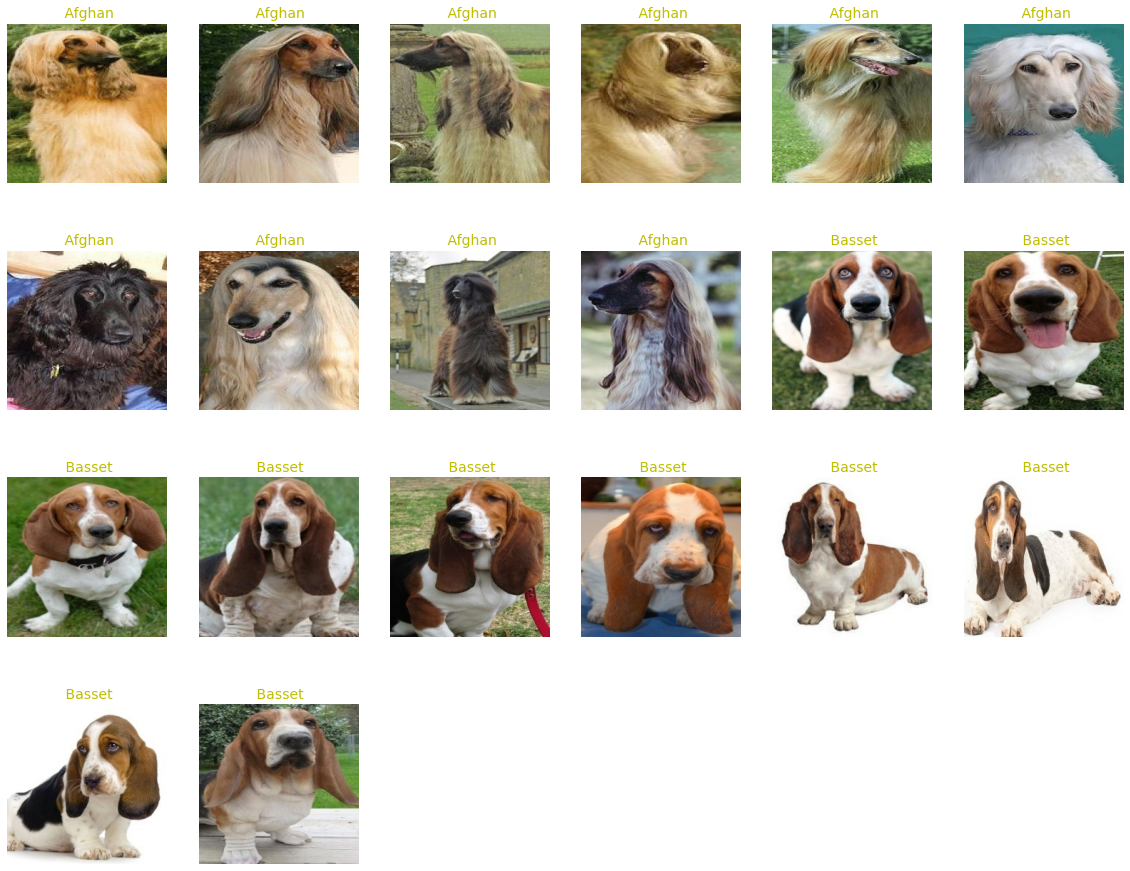

In [4]:
path_to_images=r'C:\Temp\doggies\test'
path_to_model=r'c:\temp\dog_classes\Mobilenet-97.00.h5'
path_to_class_dict=r'c:\temp\dog_classes\class_dixt.txt'
img_shape=(224,224,3)
def preprocess_function(img): #define a function to scale pixel values to what was used to train the model in this case pixels are -1 to +1
    img=img/127.5-1
    return img
def reverse_function(img_array): # define function to rescale pixel values between 0 and 1 to display images
    img_array=(img_array + 1)/2
    return img_array
show_images=True
predict_images(path_to_images, path_to_model, path_to_class_dict, img_shape, preprocess_function, show_images, reverse_function )